In [1]:
import xarray as xr
import numpy as np

import cartopy.crs as ccrs

import copy

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from WD.plotting import plot_map, add_label_to_axes


In [2]:
# usually this would go on top of the notebook:
plt.rcParams.update({'font.size': 8})  # sets font size for all cells
plt.rcParams['figure.dpi'] = 300  # sets dpi for all cells

alphabet_letters = np.array(list(map(chr, range(65, 91))))  # used for labelling subplots
textwidth = 170  # 144  # in mm
mm_to_inch = 0.0393701
textwidth = textwidth * mm_to_inch # textwidth in inches

### Load targets and predicitons:

In [20]:
ds_id = "291F23"
model_id = "D9D653"

targets = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_target.nc")
predictions = xr.load_dataset(f"/data/compoundx/WeatherDiff/model_output/{ds_id}/{model_id}_gen.nc")

diff = targets - predictions

n_images = 4

timesteps = np.random.choice(np.arange(len(predictions["init_time"])), size=(n_images,))

In [21]:
# do configurations for plotting - these can also be shared or "inherited" for plots that are similar!

config = {
    "CMAP": "viridis",
    "NORM": matplotlib.colors.Normalize(vmin=49000, vmax=59000),
    "RASTERIZED": True, # don't plot map pixels as individual points to make created files smaller
    "SHOW_COLORBAR": True,
    "CBAR_ORIENTATION": "horizontal",
    "CBAR_EXTEND": "both",
    "SHOW_COLORBAR_LABEL": False,
    "CBAR_LABEL": r"Geopotential [$m^2/s^2$]",
    "TITLE": "",
    "TITLE_FONTSIZE": 8,
    "PROJECTION": ccrs.Robinson(), # this is not called by plot_map, but by the function we create the entire plot with.
    "ASPECT_RATIO": 6/5  # can be used to calculate a figsize that looks nice for a given type of plot
}


config_diff = copy.deepcopy(config)

config_diff["CMAP"] = "RdBu"
config_diff["NORM"] = matplotlib.colors.Normalize(vmin=-3000, vmax=3000)

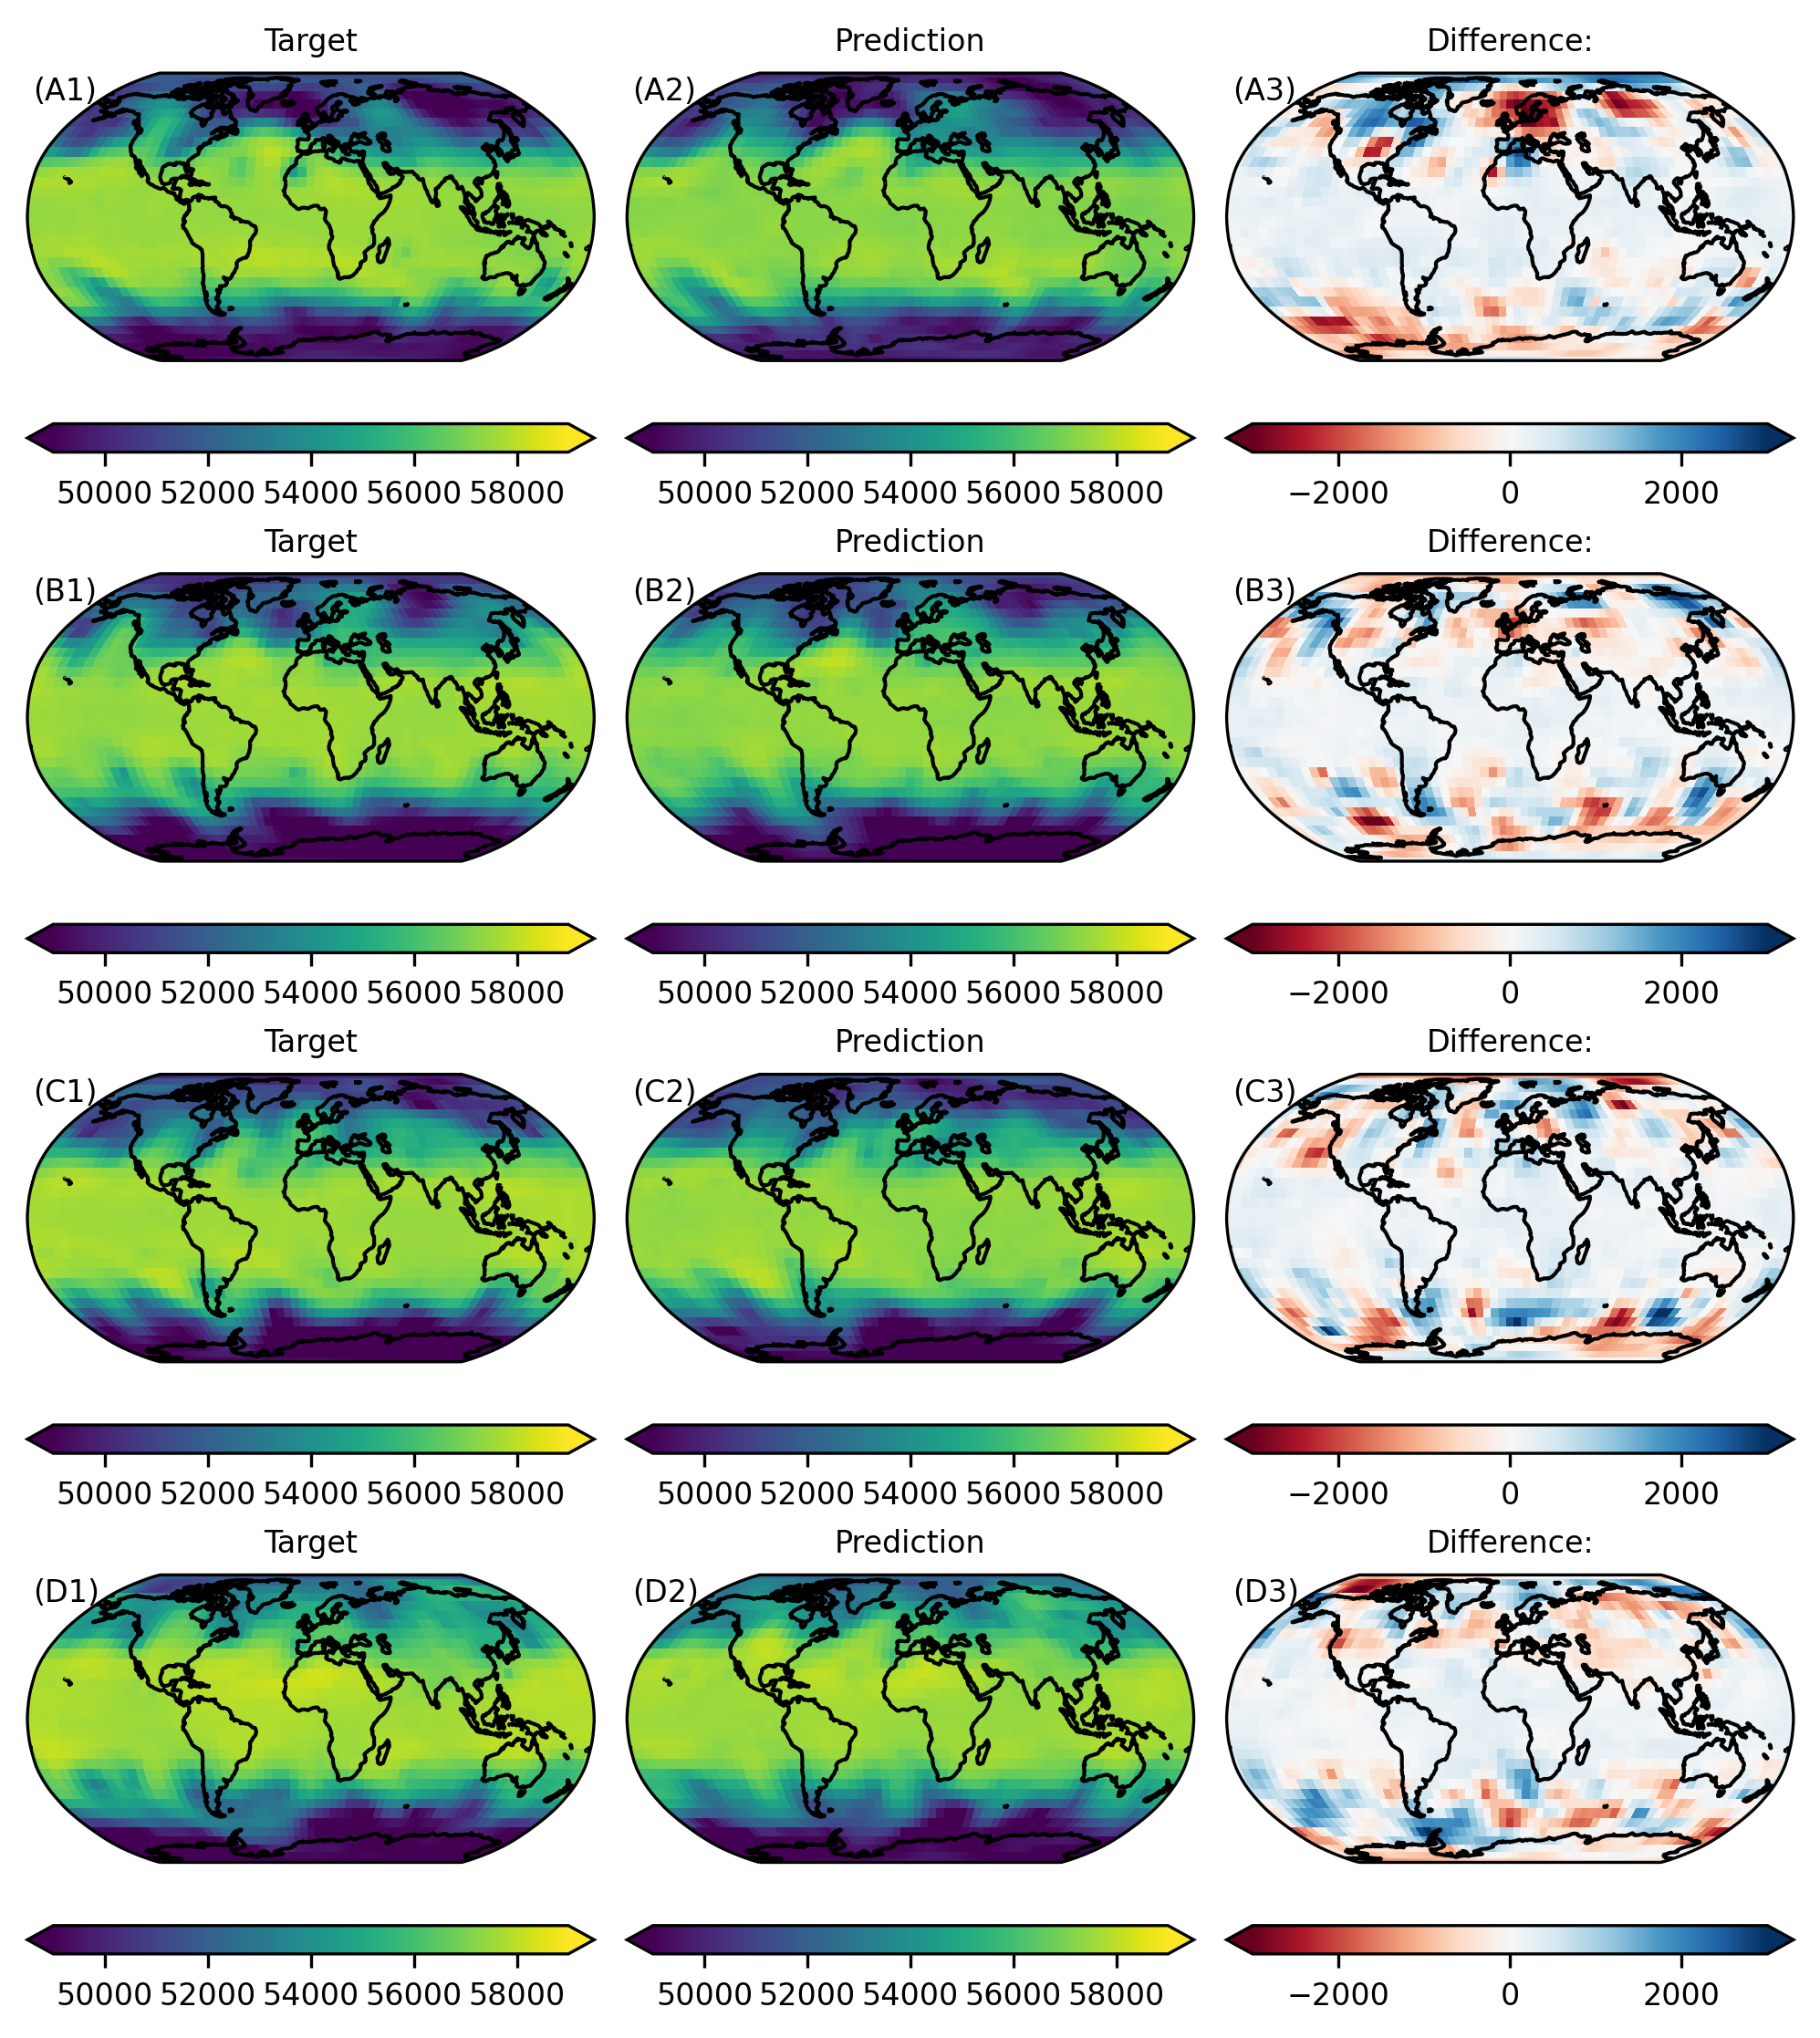

In [22]:
n_rows = n_images
n_cols = 3

figure_width = textwidth
# calculate height from number of rows, cols and aspect ratio (+ do some fine tuning)
figure_height = textwidth * (n_rows / n_cols) / config["ASPECT_RATIO"]

fig = plt.figure(figsize = [figure_width, figure_height])
gs = gridspec.GridSpec(n_rows, n_cols, figure=fig, width_ratios=[1,1,1])

for i, i_t in enumerate(timesteps):
    ax = fig.add_subplot(gs[i, 0], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=targets.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(targets.keys())], plotting_config=config, title="Target")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}1)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 1], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=predictions.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(predictions.keys())], plotting_config=config, title="Prediction")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}2)".format(alphabet_letters[i]))

    ax = fig.add_subplot(gs[i, 2], projection=config["PROJECTION"])
    # plot the map:
    plot_map(ax, data=diff.isel({"init_time":i_t, "lead_time":0, "ensemble_member": 0})[list(diff.keys())], plotting_config=config_diff, title="Difference:")
    # add a lael to the panel of the plot:
    add_label_to_axes(ax, "({}3)".format(alphabet_letters[i]))


fig.canvas.draw()
fig.tight_layout()

plt.show()

### Compute RMSE:

In [23]:
from benchmark.bm.score import compute_weighted_rmse, compute_weighted_mae, compute_weighted_acc

In [24]:
rmse = compute_weighted_rmse(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("RMSE is {:.1f}".format(rmse.z_500.values))

mae = compute_weighted_mae(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("MAE is {:.1f}".format(mae.z_500.values))

acc = compute_weighted_acc(predictions.isel({"ensemble_member": 0}), targets.isel({"ensemble_member": 0}))
print("ACC is {:.2f}".format(acc.z_500.values))

RMSE is 636.2
MAE is 418.3


ACC is 0.81


In [ ]:
# 863, 636